# Projeto: Pipeline de Pré-Processamento para Previsão de Churn

**Objetivo:** Desenvolver um pipeline completo em Python para pré-processar os dados de clientes de uma empresa de telecomunicações. O objetivo final é preparar um dataset limpo e estruturado que possa ser utilizado para treinar um modelo de Machine Learning capaz de prever o *churn* (cancelamento de serviço) de clientes.

**Dataset:** `Telco Customer Churn`

### 1. Iniciando pelo Setup e ingestão dos dados

In [1]:
# --- 1. SETUP E INGESTÃO DE DADOS ---

# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("--- Bibliotecas importadas com sucesso! ---")

# Carregar o dataset
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print(f"O dataset contém {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("Arquivo não encontrado")

display(df.head())

--- Bibliotecas importadas com sucesso! ---
O dataset contém 7043 linhas e 21 colunas.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. Análise Exploratória e Diagnóstico

Nesta etapa, nosso objetivo é investigar os dados para entender sua estrutura, identificar inconsistências, valores ausentes e obter insights iniciais sobre o problema de negócio.

--- Informações Gerais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Pa

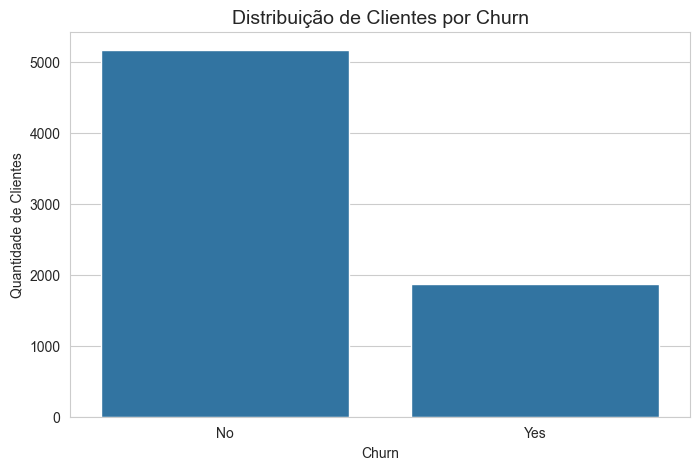

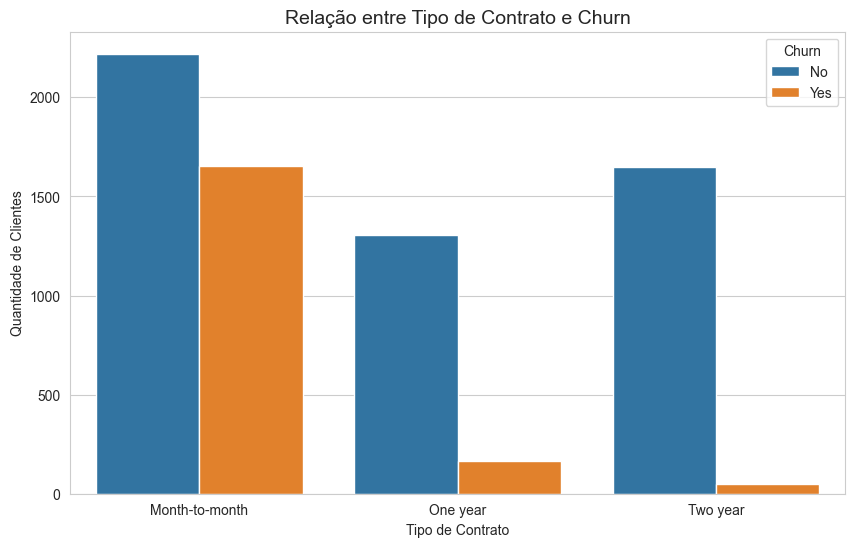

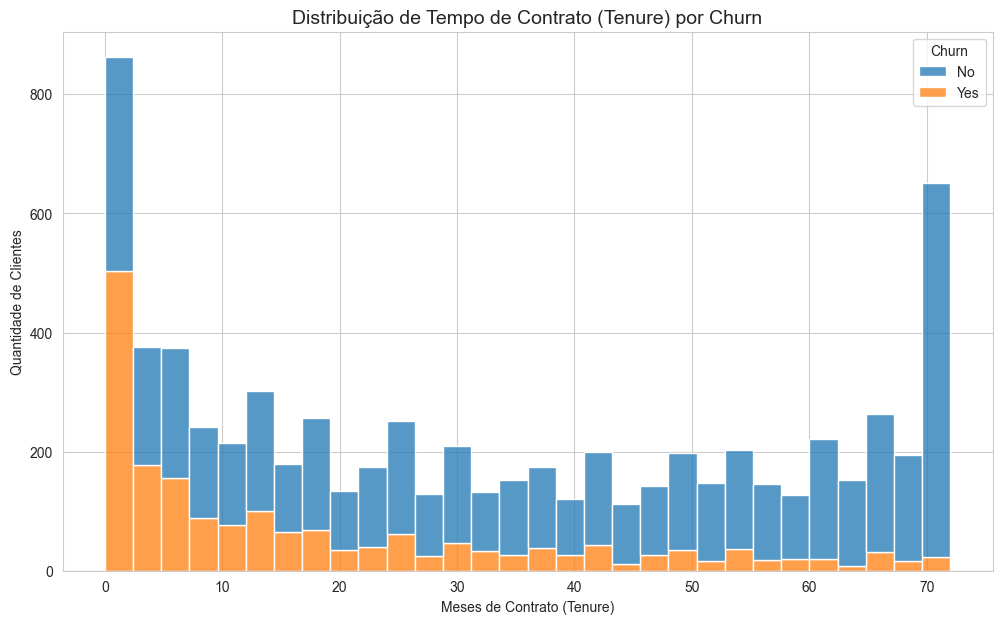

In [2]:
if 'df' in locals():
    print("--- Informações Gerais do DataFrame ---")
    df.info()

    # 'TotalCharges' é um 'object', mas deveria ser numérico.   
    # Conversão para número, valores que falharem se tornarão Nulos (NaN).
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Verificar quantos valores se tornaram nulos.
    missing_total_charges = df['TotalCharges'].isnull().sum()
    if missing_total_charges > 0:
        print(f"\n {missing_total_charges} valores não numéricos na coluna 'TotalCharges'.")
        print("Estes valores correspondem a clientes novos (tenure=0) e precisam ser tratados.\n")
    
    # --- Análise de Negócio
    
    # Gráfico 1: Distribuição da variável alvo 'Churn'
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Churn', data=df)
    plt.title('Distribuição de Clientes por Churn', fontsize=14)
    plt.ylabel('Quantidade de Clientes')
    plt.xlabel('Churn')
    plt.savefig('churn_distribution.png') 
    plt.show()
    
    # Gráfico 2: Relação entre o tipo de contrato e o Churn
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Contract', hue='Churn', data=df)
    plt.title('Relação entre Tipo de Contrato e Churn', fontsize=14)
    plt.ylabel('Quantidade de Clientes')
    plt.xlabel('Tipo de Contrato')
    plt.savefig('churn_by_contract.png') 
    plt.show()
    
    # Gráfico 3: Distribuição do tempo de contrato (tenure) por Churn
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30)
    plt.title('Distribuição de Tempo de Contrato (Tenure) por Churn', fontsize=14)
    plt.ylabel('Quantidade de Clientes')
    plt.xlabel('Meses de Contrato (Tenure)')
    plt.savefig('churn_by_tenure.png') 
    plt.show()

### **3. Limpeza de Dados**

Com base no diagnóstico, realizaremos as seguintes ações de limpeza:
1.  **Tratar `TotalCharges`:** Preencher os valores nulos (identificados na etapa anterior) com um valor apropriado. Decidimos usar a mediana da coluna, pois é uma medida robusta a outliers.
2.  **Remover `customerID`:** Esta coluna é um identificador único sem valor preditivo e será removida.

In [ ]:
if 'df' in locals():
    print("--- Iniciando Limpeza de Dados ---")
    
    # 1. Preencher os valores nulos em TotalCharges com a mediana
    median_total_charges = df['TotalCharges'].median()
    df['TotalCharges'] = df['TotalCharges'].fillna(median_total_charges)
    print(f"Valores ausentes em 'TotalCharges' preenchidos com a mediana ({median_total_charges}).")

    # 2. Remover 'customerID'
    df.drop('customerID', axis=1, inplace=True)
    print("Coluna 'customerID' removida.")
    
    print("\n--- Limpeza Concluída. Verificação: ---")
    # Verificar se ainda existem valores nulos
    print(f"Total de valores nulos no DataFrame: {df.isnull().sum().sum()}")

--- Iniciando Limpeza de Dados ---
Valores ausentes em 'TotalCharges' preenchidos com a mediana (1397.475).
Coluna 'customerID' removida.

--- Limpeza Concluída. Verificação: ---
Total de valores nulos no DataFrame: 0


C:\Users\aliss\AppData\Local\Temp\ipykernel_21984\1601175118.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(median_total_charges, inplace=True)


### **4. Transformação de Dados**

Nesta fase, preparamos os dados para o modelo de Machine Learning. Isso envolve:
1.  **Codificação da Variável Alvo:** Converter a coluna `Churn` de texto ("Yes"/"No") para formato numérico (1/0).
2.  **Codificação de Features Categóricas:** Transformar as demais colunas de texto em formato numérico usando a técnica de *One-Hot Encoding*.
3.  **Padronização de Features Numéricas:** Colocar todas as variáveis numéricas na mesma escala usando *StandardScaler* para evitar que colunas com valores maiores dominem o modelo.

In [ ]:
if 'df' in locals():
    print("--- Iniciando Transformação de Dados ---")
    
    # 1. Codificar a variável alvo 'Churn'
    if df['Churn'].dtype == 'object':
        df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
    
    # 2. Separar as features (X) da variável alvo (y)
    X = df.drop('Churn', axis=1)
    y = df['Churn']
    
    # 3. Identificar os tipos de colunas
    # Colunas numéricas que devem ser escaladas
    colunas_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']
    
    # Colunas categóricas (todas as outras) que devem ser codificadas
    colunas_categoricas = [col for col in X.columns if col not in colunas_numericas]

    print(f"\nColunas Numéricas para Padronizar: {colunas_numericas}")
    print(f"Colunas Categóricas para Codificar: {colunas_categoricas}")
    
    # 4. Pipeline de pré-processamento
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_scaler', StandardScaler(), colunas_numericas),
            ('categorical_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), colunas_categoricas)
        ],
        remainder='passthrough' 
    )
    
    # 5. Aplicar o pipeline aos dados
    X_processed = preprocessor.fit_transform(X)
    
    # 6. Criar o DataFrame final 
    # Método do scikit-learn
    # que extrai os nomes corretos diretamente do pipeline ajustado. 
    colunas_finais = preprocessor.get_feature_names_out()
    
    df_final = pd.DataFrame(X_processed, columns=colunas_finais, index=X.index)
    
    print("\n--- Transformação Concluída com Sucesso ---")
    print("Amostra do DataFrame final, pré-processado e pronto para modelagem:")
    display(df_final.head())
    
    # Salvar o dataframe processado em um CSV 
    df_final_para_salvar = pd.concat([df_final, y], axis=1)
    df_final_para_salvar.to_csv('telco_churn_processed.csv', index=False)
    print("\nDataFrame final salvo em 'telco_churn_processed.csv'")

--- Iniciando Transformação de Dados ---

Colunas Numéricas para Padronizar: ['tenure', 'MonthlyCharges', 'TotalCharges']
Colunas Categóricas para Codificar: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

--- Transformação Concluída com Sucesso ---
Amostra do DataFrame final, pré-processado e pronto para modelagem:


,numeric_scaler__tenure,numeric_scaler__MonthlyCharges,numeric_scaler__TotalCharges,categorical_encoder__gender_Male,categorical_encoder__SeniorCitizen_1,categorical_encoder__Partner_Yes,categorical_encoder__Dependents_Yes,categorical_encoder__PhoneService_Yes,categorical_encoder__MultipleLines_No,categorical_encoder__MultipleLines_No phone service,...,categorical_encoder__StreamingMovies_No internet service,categorical_encoder__StreamingMovies_Yes,categorical_encoder__Contract_Month-to-month,categorical_encoder__Contract_One year,categorical_encoder__Contract_Two year,categorical_encoder__PaperlessBilling_Yes,categorical_encoder__PaymentMethod_Bank transfer (automatic),categorical_encoder__PaymentMethod_Credit card (automatic),categorical_encoder__PaymentMethod_Electronic check,categorical_encoder__PaymentMethod_Mailed check
0,-1.277445,-1.160323,-0.994242,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.066327,-0.259629,-0.173244,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.236724,-0.362660,-0.959674,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.514251,-0.746535,-0.194766,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.236724,0.197365,-0.940470,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0



DataFrame final salvo em 'telco_churn_processed.csv'


### **5. Relatório Final**

#### **Resumo do Projeto**
Este projeto implementou um pipeline de pré-processamento de dados para o dataset "Telco Customer Churn". O objetivo foi transformar os dados brutos em um formato limpo, estruturado e adequado para a criação de um modelo preditivo de *churn*.

#### **Decisões e Justificativas**
- **Tratamento de `TotalCharges`:** A conversão da coluna `TotalCharges` para formato numérico revelou valores nulos correspondentes a clientes novos. Optou-se por preencher esses valores com a **mediana** da coluna para minimizar o impacto valores extremos.
- **Codificação de Categóricos:** Foi utilizado o **One-Hot Encoding** para as variáveis categóricas. Essa técnica foi escolhida por ser ideal para variáveis nominais (sem ordem intrínseca), evitando que o modelo interprete erroneamente uma ordem que não existe. O parâmetro `drop='first'` foi usado para evitar multicolinearidade.
- **Padronização de Numéricos:** As variáveis numéricas foram padronizadas com **StandardScaler**. Fundamental para algoritmos sensíveis à escala (como Regressão Logística ou SVMs), garantindo que todas as features contribuam de forma equilibrada para o resultado.

#### **Resultado**
O pipeline gerou um DataFrame final contendo **45 features** (após o One-Hot Encoding), todas em formato numérico e padronizadas. Este dataset está pronto para ser utilizado na próxima fase do ciclo de vida de Machine Learning: a **modelagem**.